# Apresentação da classe `Transmissor`

## Objetivos
Simular o funcionamento de um transmissor de sinais digitais.

### Definição da classe `Transmissor`

In [2]:
# Importando libs necessárias
import numpy as np
import socket, pickle
import matplotlib.pyplot as plt
from mod_8qam import Mod_8qam

Obs.: Para uma maior legibilidade, esconda os detalhes de implementação na célula seguinte.

In [3]:
class Transmissor:
    def __init__(self, received_text: str, host='127.0.0.1', port=65432):
        self.host = host
        self.port = port
        self.received_text = received_text
        self.bit_array = self.__text_2_binary(received_text)


    def __text_2_binary(self, text):
        """ Converts text to binary """
        bits_str = ''
        for byte in text.encode('utf8'):
            byte = f'{byte:08b}' # convert byte to a byte string 
            bits_str += byte
        return [int(bit) for bit in bits_str] # returns a list of bits
    



# Run methods start ---------------------------------------------------------------------------------------------------------------------

    def run(self, encoding_method, framing_method, error_correction_or_detection_method,  modulation_method):
        self.encoded_bits = self.coder(encoding_method)

        

        match encoding_method.lower():
            case "nrz":	# -1 -> 0; 1 -> 1
                self.encoded_bits_cleaned = [0 if bits != 1 else 1 for bits in self.encoded_bits]
            case "bipolar":	# 0 -> 0; (-1,1) -> 1
                self.encoded_bits_cleaned = [0 if (bits == 0) else 1 for bits in self.encoded_bits]
            case "manchester":	# 0 -> 0; 1 -> 1
                self.encoded_bits_cleaned = self.encoded_bits



        match framing_method.lower():
            case "character_count":
                self.frames = self.character_count_framing(self.encoded_bits_cleaned, 8)
            case "byte_insertion":
                self.frames = self.bytes_insertion_framing(self.encoded_bits_cleaned, 8)
            case "bits_insertion":
                self.frames = self.bits_insertion_framing(self.encoded_bits_cleaned, 64) # 64 bits (8 bytes) per frame

        
        match error_correction_or_detection_method.lower():
            case "even_parity":
                self.frames_final = self.adjust_frames_even_parity(self.frames, framing_method)
            case "crc":
                self.frames_final = self.adjust_frames_crc(self.frames, framing_method)
            case "hamming":
                self.frames_final = self.adjust_frames_hamming(self.frames, framing_method)

        print(self.frames_final)
        bits_vector = [bit for frame in self.frames_final for bit in frame] # convert the frames matrix to a big bit vector
        match modulation_method.lower():
            case "ask":
                self.signal = self.ASK(1, 1, bits_vector)
            case "fsk":
                self.signal = self.FSK(1, 1, 2, bits_vector)
            case "8qam":
                self.signal = self.modulacao_8qam(bits_vector)
        

        bits_vector_str = ''.join(map(str, bits_vector))

        self.send_message(bits_vector_str)

        return self.bit_array, self.encoded_bits, self.signal

# Run methods end ---------------------------------------------------------------------------------------------------------------------





# Adjust frames methods start ---------------------------------------------------------------------------------------------------------------------

    def adjust_frames_even_parity(self, frames, framing_method):
        """ Add even parity bit to each frame """
        match framing_method.lower():
            case "character_count":
                new_frames = []
                for frame in frames:
                    unified_frame_array = [int(bit) for bit in ''.join(frame[1:])] # convert the frame to a bit array
                    frame_with_parity = self.add_even_parity_bit(unified_frame_array) # add parity bit to the frame

                    remainder = len(frame_with_parity) % 8 # calculate the remainder of the division by 8
                    padding_needed = 8 - remainder # calculate the number of padding bits needed to make the frame size a multiple of 8
                    padding_bits = padding_needed % 8 # if the remainder is 0 or 8, no padding is needed

                    padded_frame = frame_with_parity + [0] * padding_bits

                    padding_header = [int(bit) for bit in f"{padding_bits:08b}"] # creates a header to indicate how many padding bits were added

                    byte_count = len(padded_frame) // 8 # calculate the number of bytes in the frame
                    frame_header = [int(bit) for bit in f"{byte_count+2:08b}"] # update the byte count header

                    new_frame = frame_header + padding_header + padded_frame # remove the first byte (byte count header) and combine everything in a new frame
                    new_frames.append(new_frame)

                return new_frames # returns a list of a frame list of int(bits)
            

            case "byte_insertion":
                new_frames = []

                for frame in frames:
                    flag_init = [int(bit) for bit in frame[0]]
                    flag_end = [int(bit) for bit in frame[-1]]

                    unified_frame_array = [int(bit) for bit in ''.join(frame[1:-1])]
                    frame_with_parity = self.add_even_parity_bit(unified_frame_array)

                    remainder = len(frame_with_parity) % 8
                    padding_needed = 8 - remainder
                    padding_bits = padding_needed % 8

                    padded_frame = frame_with_parity + [0] * padding_bits

                    padding_header = [int(bit) for bit in f"{padding_bits:08b}"]

                    new_frame = flag_init + padding_header + padded_frame + flag_end
                    new_frames.append(new_frame)

                return new_frames # returns a list of a frame list of int(bits)
            

            case "bits_insertion":
                new_frames = []

                for frame in frames:
                    flag_init = [int(bit) for bit in frame[:8]]
                    flag_end = [int(bit) for bit in frame[-8:]]

                    unified_frame_array = [int(bit) for bit in ''.join(frame[8:-8])]
                    frame_with_parity = self.add_even_parity_bit(unified_frame_array)

                    new_frame = flag_init + frame_with_parity  + flag_end
                    new_frames.append(new_frame)
                
                return new_frames # returns a list of a frame list of int(bits)



    def adjust_frames_crc(self, frames, framing_method):

        match framing_method.lower():
            case "character_count":
                new_frames = []
                for frame in frames:
                    unified_frame_array = [int(bit) for bit in ''.join(frame[1:])]
                    frame_with_crc, inserted_bits_len = self.crc32(unified_frame_array)

                padding_header = [int(bit) for bit in f"{inserted_bits_len:08b}"] # creates a header to indicate how many padding bits were added

                byte_count = len(frame_with_crc) // 8 # calculate the number of bytes in the frame
                frame_header = [int(bit) for bit in f"{byte_count+2:08b}"] # update the byte count header, +1 to count the header

                new_frame = frame_header + padding_header + frame_with_crc # remove the first byte (byte count header) and combine everything in a new frame
                new_frames.append(new_frame)

                return new_frames # returns a list of a frame list of int(bits)
            

            case "byte_insertion":
                new_frames = []

                for frame in frames:
                    flag_init = [int(bit) for bit in frame[0]]
                    flag_end = [int(bit) for bit in frame[-1]]

                    unified_frame_array = [int(bit) for bit in ''.join(frame[1:-1])]
                    frame_with_crc, inserted_bits_len = self.crc32(unified_frame_array)

                    padding_header = [int(bit) for bit in f"{inserted_bits_len:08b}"]

                    new_frame = flag_init + padding_header + frame_with_crc + flag_end
                    new_frames.append(new_frame)

                return new_frames # returns a list of a frame list of int(bits)
            

            case "bits_insertion":
                new_frames = []

                for frame in frames:
                    flag_init = [int(bit) for bit in frame[:8]]
                    flag_end = [int(bit) for bit in frame[-8:]]

                    unified_frame_array = [int(bit) for bit in ''.join(frame[8:-8])]
                    frame_with_crc, inserted_bits_len = self.crc32(unified_frame_array)

                    padding_header = [int(bit) for bit in f"{inserted_bits_len:08b}"]

                    new_frame = flag_init + padding_header + frame_with_crc + flag_end
                    new_frames.append(new_frame)

                return new_frames # returns a list of a frame list of int(bits)
            


    def adjust_frames_hamming(self, frames, framing_method):

        match framing_method.lower():
            case "character_count":
                new_frames = []
                for frame in frames:
                    unified_frame_array = [int(bit) for bit in ''.join(frame[1:])]
                    frame_with_hamming = self.apply_hamming_code(unified_frame_array)

                    remainder = len(frame_with_hamming) % 8
                    padding_needed = 8 - remainder
                    padding_bits = padding_needed % 8

                    padded_frame = frame_with_hamming + [0] * padding_bits

                    padding_header = [int(bit) for bit in f"{padding_bits:08b}"] # creates a header to indicate how many padding bits were added

                    byte_count = len(padded_frame) // 8 # calculate the number of bytes in the frame
                    frame_header = [int(bit) for bit in f"{byte_count+2:08b}"] # update the byte count header

                    new_frame = frame_header + padding_header + padded_frame # remove the first byte (byte count header) and combine everything in a new frame
                    new_frames.append(new_frame)

                return new_frames # returns a list of a frame list of int(bits)
            

            case "byte_insertion":
                new_frames = []

                for frame in frames:
                    flag_init = [int(bit) for bit in frame[0]]
                    flag_end = [int(bit) for bit in frame[-1]]

                    unified_frame_array = [int(bit) for bit in ''.join(frame[1:-1])]
                    frame_with_hamming = self.apply_hamming_code(unified_frame_array)

                    remainder = len(frame_with_hamming) % 8
                    padding_needed = 8 - remainder
                    padding_bits = padding_needed % 8

                    padded_frame = frame_with_hamming + [0] * padding_bits

                    new_frame = flag_init + padded_frame + flag_end
                    new_frames.append(new_frame)

                return new_frames # returns a list of a frame list of int(bits)
            

            case "bits_insertion":
                new_frames = []

                for frame in frames:
                    flag_init = [int(bit) for bit in frame[:8]]
                    flag_end = [int(bit) for bit in frame[-8:]]

                    unified_frame_array = [int(bit) for bit in ''.join(frame[8:-8])]
                    frame_with_hamming = self.apply_hamming_code(unified_frame_array)

                    new_frame = flag_init + frame_with_hamming + flag_end
                    new_frames.append(new_frame)

                return new_frames # returns a list of a frame list of int(bits)

# Adjust frames methods end ---------------------------------------------------------------------------------------------------------------------



# Enconding methods start ---------------------------------------------------------------------------------------------------------------------

    def coder(self, encoding_method):
        match encoding_method.lower():
            case "nrz":
                return self.polar_nrz_coder(self.bit_array)
            case "manchester":
                print("bits_cleanded transmissor", self.bit_array)
                print()
                print()
                return self.manchester_coder(self.bit_array)
            case "bipolar":
                return self.bipolar_coder(self.bit_array)
        

    def polar_nrz_coder(self, bit_array):
        output = [bit if bit == 1 else -1 for bit in bit_array]
        return output

    
    def manchester_coder(self, bit_array): 
        output = [[0, 1] if bit == 0 else [1, 0] for bit in bit_array]
        output = [bit for two_bit_list in output for bit in two_bit_list]
        return output
    

    def bipolar_coder(self, bit_array):
        output = bit_array.copy()
        flip = False
        for i, bit in enumerate(output):
            if bit == 1 and not flip:
                output[i] = 1
                flip = not flip
            elif bit == 1 and flip:
                output[i] = -1
                flip = not flip
        return output

# Enconding methods end ---------------------------------------------------------------------------------------------------------------------
    


# Framing methods start ---------------------------------------------------------------------------------------------------------------------

    def character_count_framing(self, bits_array, max_frame_size): # limit of max_frame_size is 256
        """Return a matrix of frames, each frame is a list of strings of 8 bits"""
        frames_matrix = []
        bytes_list = [''.join(map(str, bits_array[i:i+8])) for i in range(0, len(bits_array), 8)] # bytes list is a array of strings of 8 bits

        while bytes_list:
            frame_size = min(len(bytes_list), max_frame_size - 1) 
            frame = [f"{frame_size+1:08b}"] + bytes_list[:frame_size] # +1 for the header, because the header matter in the frame size
            frames_matrix.append(frame)
            bytes_list = bytes_list[frame_size:]

        return frames_matrix
    

    def bytes_insertion_framing(self, bits_array, max_frame_size): # max_frame_size is the number of ****bytes**** in a frame
        """Return a matrix of frames, each frame is a list of strings of 8 bits"""
        frames_matrix = []
        bytes_list = [''.join(map(str, bits_array[i:i+8])) for i in range(0, len(bits_array), 8)] # Bytes list is a array of strings of 8 bits
        byte_flag = "01111110"

        while bytes_list:
            frame_size = min(len(bytes_list), max_frame_size-2)  # -2 for the flags
            frame = [byte_flag] + bytes_list[:frame_size] + [byte_flag]
            frames_matrix.append(frame)
            bytes_list = bytes_list[frame_size:]
            
        return frames_matrix 
    

    def bits_insertion_framing(self, bits_array, max_frame_size): # max_frame_size is the number of ****bits**** in a frame
        """Return a list of frames, each frame is a string of bits"""
        frames_list = []
        flag = "01111110"

        for i in range(0, len(bits_array), max_frame_size):
            frame = ''.join(map(str, bits_array[i:i+max_frame_size]))
            frames_list.append(flag + frame + flag)

        return frames_list
    

# Framing methods end ---------------------------------------------------------------------------------------------------------------------
    



# Error correction or detection methods start ---------------------------------------------------------------------------------------------------------------------

    def add_even_parity_bit(self, bits_array):
        count_ones = sum(bits_array)
        parity_bit = 0

        if count_ones % 2 != 0:
            parity_bit = 1

        return bits_array + [parity_bit]
    


    def crc32(self, bit_array):
        inserted_bits_len = 0

        crc32_polynomial = 0x104C11DB7 # polynomial used by CRC32 IEEE 802 (0x04C11DB7 without the occlusion of the first bit)
        crc32_polynomial_str = f"{crc32_polynomial:033b}" # 32 0's to complete the 96 bits

        def xor(bit_str_a, bit_str_b): # xor between two bit strings
            bit_str_result = ''
            for i in range(len(bit_str_a)):
                if bit_str_a[i] == bit_str_b[i]: # if the bits are equal, the result is 0
                    bit_str_result += '0'
                else: # if the bits are different, the result is 1
                    bit_str_result += '1'
            return bit_str_result

        def gen_0_1_sequence(len_array): # generate a sequence of 0's and 1's
            array = []
            for i in range(len_array):
                if i % 2 == 0: # if the index is even, the bit is 0
                    array.append(0)
                else: # if the index is odd, the bit is 1
                    array.append(1)
            return array

        if len(bit_array) < 64: # if the bit array is less than 64 bits, complete with 0's and 1's (to avoid large sequences of 0's)
            inserted_int_bits = gen_0_1_sequence(64 - len(bit_array)) # 0's and 1's to complete the 64 bits
            bit_array = bit_array + inserted_int_bits
            inserted_bits_len = len(inserted_int_bits)

        bit_str = ''.join(map(str, bit_array)) # convert the bit array to a bit string
        bit_str_initial = bit_str

        bit_str = bit_str + '0'*32 # 32 0's to complete the 96 bits     
        bit_str_to_xor = ''
        for i in range(len(bit_str)): # for each bit in the bit string
            if i <= 32: # if the bit is in the first 32 bits
                bit_str_to_xor += bit_str[i]
            else: # if the bit is in the last 64 bits
                if bit_str_to_xor[0] == '1':
                    bit_str_to_xor = xor(bit_str_to_xor, crc32_polynomial_str) # xor with the polynomial
                    bit_str_to_xor = bit_str_to_xor[1:] + bit_str[i] # exclude the first bit (0) and include the next bit
                else:
                    bit_str_to_xor = bit_str_to_xor[1:] + bit_str[i] # exclude the first bit (0) and include the next bit

            if i == len(bit_str) - 1: # if it is the last bit
                if bit_str_to_xor[0] == '1': # if the first bit is 1, xor with the polynomial
                    bit_str_to_xor = xor(bit_str_to_xor, crc32_polynomial_str)
                    bit_str_to_xor = bit_str_to_xor[1:] # exclude the first bit (0)

                else: # if the first bit is 0, xor with 33 0's
                    bit_str_to_xor = bit_str_to_xor[1:] # exclude the first bit (0)

        return list(bit_str_initial + bit_str_to_xor), inserted_bits_len



    def apply_hamming_code(self, bit_array): # Apply the Hamming Code to the provided bit array.
        def find_len_redundant_bits(len_bits): 
            """Find the number of redundant bits required for a message of length len_bits."""
            for i in range(len_bits):
                if(2**i >= len_bits + i + 1):
                    return i			
                
        def insert_zeros_parity_position(bit_array): 
            """Insert zeros in the parity positions."""
            len_redudant_bits = find_len_redundant_bits(len(bit_array))

            for i in range(len_redudant_bits):
                bit_array.insert((2**i)-1, 0)

            return bit_array		

        def calculate_parity_bit(bit_array, position): # position must be one of the power of 2 (1, 2, 4, 8, 16, ...)
            """Calculate the parity bit for the given position."""
            temp_bit_array = bit_array[position-1:]
            list_of_bits = []
            jump = False # jump must be started with False to collect the first bits of the bit_array according to the position
            for i in range(0, len(bit_array), position):
                if jump:
                    jump = False
                    continue

                list_of_bits.extend(temp_bit_array[i:i+position]) # if i+position is greater than the length of the temp_bit_array, it will not be a problem because the slice will be until the end of the list
                jump = True        

            parity = list_of_bits[1] # The first bit is the parity bit itself
            list_of_bits = list_of_bits[2:] # Remove the first bit because it is the 0 that was included

            for bit in list_of_bits:
                parity ^= bit

            return parity				

        def insert_parity_bits(bit_array):
            """Return the bit array with the parity bits."""
            len_redudant_bits = find_len_redundant_bits(len(bit_array))
            bit_array = insert_zeros_parity_position(bit_array)

            for i in range(len_redudant_bits):
                position = (2**i)
                bit_array[position-1] = calculate_parity_bit(bit_array, position) # position-1 because the list starts with index 0

            return bit_array
        
        return insert_parity_bits(bit_array)

# Error correction or detection methods end ---------------------------------------------------------------------------------------------------------------------



# Modulation methods start ---------------------------------------------------------------------------------------------------------------------

    def ASK(self, A, f, bit_array):
        tam_sinal = len(bit_array)
        sinal = np.zeros(tam_sinal*100, dtype=float)

        for i in range(tam_sinal):
            if self.bits_codificados_binario[i] == 1:
                for j in range(100):
                    sinal[i*100 + j] = A * np.sin(2*np.pi*f*j/100)
            else:
                for j in range(100):
                    sinal[i*100 + j] = 0

        return sinal

    
    def FSK(self, A, f1, f2, bit_array):
        """ Modular a frequência do sinal """
        tam_sinal = len(bit_array)
        sinal = np.zeros(tam_sinal*100, dtype=float)

        for i in range(tam_sinal):
            if bit_array[i] == 1:
                for j in range(100):
                    sinal[i*100 + j] = A * np.sin(2*np.pi*f1*j/100)
            else:
                for j in range(100):
                    sinal[i*100 + j] = A * np.sin(2*np.pi*f2*j/100)

        return sinal




    def ASK(self, A, f, bit_array): # Amplitude Shift Keying
        len_signal = len(bit_array)
        signal = np.zeros(len_signal*100, dtype=float)

        for i in range(len_signal):
            if bit_array[i] == 1:
                for j in range(100):
                    signal[i*100 + j] = A * np.sin(2*np.pi*f*j/100)
            else:
                for j in range(100):
                    signal[i*100 + j] = 0

        return signal


    def FSK(self, A, f1, f2, bit_array): # Frequency Shift Keying
        len_signal = len(bit_array)
        signal = np.zeros(len_signal*100, dtype=float)

        for i in range(len_signal):
            if bit_array[i] == 1:
                for j in range(100):
                    signal[i*100 + j] = A * np.sin(2*np.pi*f1*j/100)
            else:
                for j in range(100):
                    signal[i*100 + j] = A * np.sin(2*np.pi*f2*j/100)

        return signal

    def modulacao_8qam(self, bits):
        mod_8qam = Mod_8qam()
        bauds, tempo, sinal_banda_base = mod_8qam.run(bits)
        return [bauds, tempo, sinal_banda_base]

# Modulation methods end ---------------------------------------------------------------------------------------------------------------------

    # Send digitally encoded message to receiver through socket
    def send_message(self, bits_vector_str):

        socket_client = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        socket_client.connect((self.host, self.port))

        dados = pickle.dumps(bits_vector_str)
        socket_client.send(dados)

        received_data = socket_client.recv(4096)

        socket_client.close()

        return received_data

## Construtor


Aqui podemos ver a definição da classe `Transmissor` que recebe como parâmetro o texto recebido em seu construtor.

```py

class Transmissor:
    def __init__(self, received_text: str, host="localhost", port=8888):
        self.host = host
        self.port = port
        self.received_text = received_text
        self.bit_array = self.__text_2_binary(received_text)

    def __text_2_binary(self, text):
        """ Converts text to binary """
        bits_str = ''
        for byte in text.encode('utf8'):
            byte = f'{byte:08b}'  # convert byte to a byte string
            bits_str += byte
        return [int(bit) for bit in bits_str]  # returns a list of bits
```

Também é definido o método`__text_2_binary` que recebe o texto recebido no simulador e o transforma em uma sequência de bits.

Exemplo:

In [4]:
message = "Hello World!"
transmissor = Transmissor(message)
print(f"{message} in binary (bit array): {transmissor.bit_array}")

Hello World! in binary (bit array): [0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]


## Método `run`

```py

def run(self, encoding_method, framing_method, error_correction_or_detection_method,  modulation_method):
    self.encoded_bits = self.coder(encoding_method)

    match encoding_method.lower():
        case "nrz":  # -1 -> 0; 1 -> 1
            self.encoded_bits_cleaned = [
                0 if b != 1 else 1 for b in self.encoded_bits]
        case "bipolar":  # 0 -> 0; (-1,1) -> 1
            self.encoded_bits_cleaned = [
                0 if (b == 0) else 1 for b in self.encoded_bits]
        case "manchester":  # 0 -> 0; 1 -> 1
            self.encoded_bits_cleaned = self.encoded_bits

    match framing_method.lower():
        case "character_count":
            self.frames = self.character_count_framing(
                self.encoded_bits_cleaned, 8)
        case "byte_insertion":
            self.frames = self.bytes_insertion_framing(
                self.encoded_bits_cleaned, 8)
        case "bits_insertion":
            self.frames = self.bits_insertion_framing(
                self.encoded_bits_cleaned, 8)

    match error_correction_or_detection_method.lower():
        case "even_parity":
            self.frames_final = self.adjust_frames_even_parity(
                self.frames, framing_method)
        case "crc":
            self.frames_final = self.adjust_frames_crc(
                self.frames, framing_method)
        case "hamming":
            self.frames_final = self.adjust_frames_hamming(
                self.frames, framing_method)

    # convert the frames matrix to a big bit vector
    bits_vector = [bit for frame in self.frames_final for bit in frame]
    match modulation_method.lower():
        case "ask":
            self.sinal = self.ASK(1, 1, bits_vector)
        case "fsk":
            self.sinal = self.FSK(1, 1, 2, bits_vector)
        case "8qam":
            self.sinal = self.QAM(1, 1, 2, bits_vector)


    self.send_message(self.sinal)
    
    return self.bit_array, self.encoded_bits, self.sinal
```

No método `run` é onde a tudo acontece. Ele recebe método de codificação, enquadramento, detecção ou correção de erro e modulação e retorna:

- O texto recebido no simulador em forma de bits
- O texto recebido já codificado para o método escolhido
- O sinal modulado

Os dois primeiros são utilizados apenas para o display da interface. O sinal modulado será o sinal recebido pela classe `Receptor`.

## Métodos de codificação

```py

def coder(self, encoding_method):
    match encoding_method.lower():
        case "nrz":
            return self.polar_nrz_coder(self.bit_array)
        case "manchester":
            return self.manchester_coder(self.bit_array)
        case "bipolar":
            return self.polar_nrz_coder(self.bit_array)

```

O método `coder` define qual o método de codificação a ser utilizado. Agora iremos definir as lógicas de cada um deles.

### NRZ

```py

def polar_nrz_coder(self, bit_array):
    output = [bit if bit == 1 else -1 for bit in bit_array]
    return output
````

Esse é o método mais simples de codificação. Se o bit recebido for 0, o sinal será -1. Se for 1, o sinal será 1.

Os sinais representam tensões, então, se o sinal for -1, a tensão será -1V. Se for 1, a tensão será 1V.

Exemplo:

Hello World! in NRZ: [0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]


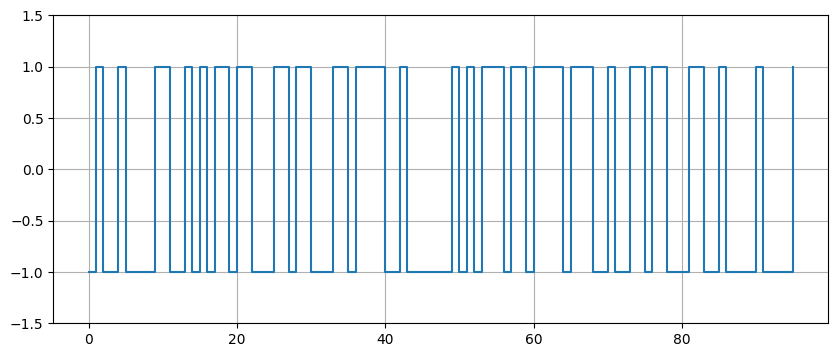

In [5]:
transmissor = Transmissor(message)

nrz = transmissor.polar_nrz_coder(transmissor.bit_array)

print(f"{message} in NRZ: {transmissor.bit_array}")

# Create a time vector from 0 to the length of the binary sequence
t = np.arange(len(nrz))

# Plot the binary wave
plt.figure(figsize=(10, 4))
plt.step(t, nrz, where='post')
plt.ylim([-1.5, 1.5])
plt.grid(True)
plt.show()

## Manchester

```py

def manchester_coder(self, bit_array):
    output = [[0, 1] if bit == 0 else [1, 0] for bit in bit_array]
    output = [bit for two_bit_list in output for bit in two_bit_list]
    return output

```


Esse método é um pouco mais complexo. Ele utiliza dois sinais para representar um bit. Se o bit for 0, o sinal será -1 e 1. Se for 1, o sinal será 1 e -1.

Exemplo:

Hello World! in manchester: [0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0]


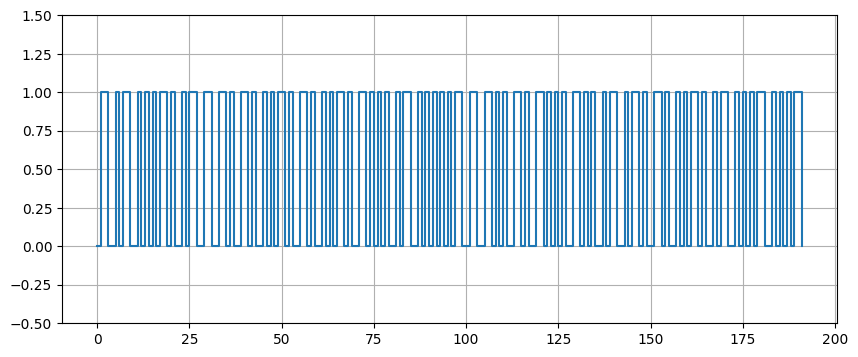

In [6]:
manchester = transmissor.manchester_coder(transmissor.bit_array)

print(f"{message} in manchester: {manchester}")

# Create a time vector from 0 to the length of the binary sequence
t = np.arange(len(manchester))

# Plot the binary wave
plt.figure(figsize=(10, 4))
plt.step(t, manchester, where='post')
plt.ylim([-0.5, 1.5])
plt.grid(True)
plt.show()


## Bipolar

```py

def bipolar_coder(self, bit_array):
    output = bit_array.copy()
    flip = False
    for i, bit in enumerate(output):
        if bit == 1 and not flip:
            output[i] = 1
            flip = not flip
        elif bit == 1 and flip:
            output[i] = -1
            flip = not flip
    return output
```

Este código converte uma sequência de bits binários (0s e 1s) em um sinal bipolar, onde os valores são alternados entre 1 e -1 para cada sequência contínua de 1s no input.

Exemplo:

Hello World! in bipolar: [0, 1, 0, 0, -1, 0, 0, 0, 0, 1, -1, 0, 0, 1, 0, -1, 0, 1, -1, 0, 1, -1, 0, 0, 0, 1, -1, 0, 1, -1, 0, 0, 0, 1, -1, 0, 1, -1, 1, -1, 0, 0, 1, 0, 0, 0, 0, 0, 0, -1, 0, 1, 0, -1, 1, -1, 0, 1, -1, 0, 1, -1, 1, -1, 0, 1, -1, 1, 0, 0, -1, 0, 0, 1, -1, 0, 1, -1, 0, 0, 0, 1, -1, 0, 0, 1, 0, 0, 0, 0, -1, 0, 0, 0, 0, 1]


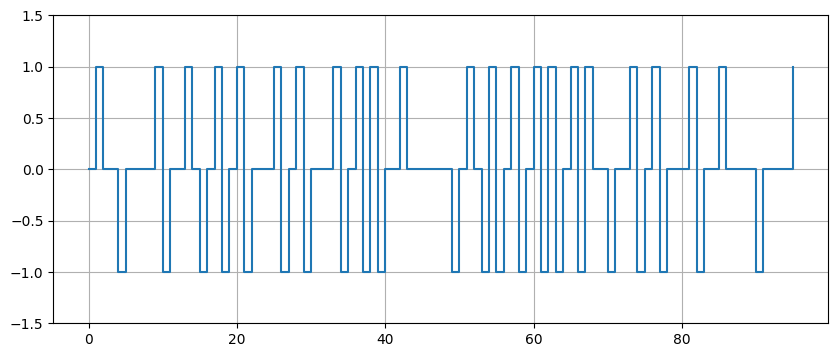

In [7]:
transmissor = Transmissor(message)

bipolar = transmissor.bipolar_coder(transmissor.bit_array)

print(f"{message} in bipolar: {bipolar}")

# Create a time vector from 0 to the length of the binary sequence
t = np.arange(len(bipolar))

# Plot the binary wave
plt.figure(figsize=(10, 4))
plt.step(t, bipolar, where='post')
plt.ylim([-1.5, 1.5])
plt.grid(True)
plt.show()

## Métodos de modulação

O sinal de dados a ser transmitido modifica características da portadora de 3 formas diferentes, apresentadas a seguir: 

### ASK
```py

def ASK(self, A, f, bit_array):  # Amplitude Shift Keying
    len_signal = len(bit_array)
    signal = np.zeros(len_signal*100, dtype=float)

    for i in range(len_signal):
        if bit_array[i] == 1:
            for j in range(100):
                signal[i*100 + j] = A * np.sin(2*np.pi*f*j/100)
        else:
            for j in range(100):
                signal[i*100 + j] = 0

    return signal
````

A modulação de amplitude (Amplitude Shift Keying) modifica a amplitude da portadora de acordo com o sinal de dados. Quando o bit é 1, é gerada uma onda senoidal de frequência *f* e amplitude *A*, e se o bit é 0, a modulação não gera uma onda (amplitude 0).

Para cada bit de entrada, 100 pontos são desenhados no gráfico. 

'Olá' in NRZ - ASK: [-1, 1, -1, -1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, 1, -1, -1, -1, -1, 1]


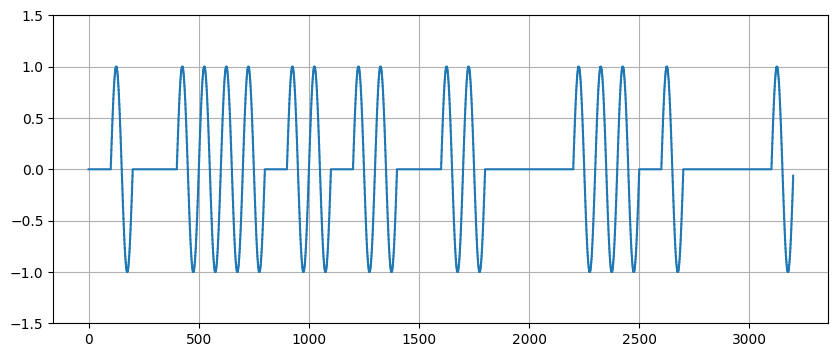

In [8]:
message_mod = "Olá"
transmissor = Transmissor(message_mod)
nrz_mod = transmissor.polar_nrz_coder(transmissor.bit_array)

A = 1
f1 = 1
ask = transmissor.ASK(A, f1, nrz_mod)

print(f"'{message_mod}' in NRZ - ASK: {nrz_mod}")

t = np.arange(len(ask))

plt.figure(figsize=(10, 4))
plt.step(t, ask, where='post')
plt.ylim([-1.5, 1.5])
plt.grid(True)
plt.show()


### FSK
```py
def FSK(self, A, f1, f2, bit_array):    # Frequency Shift Keying
    len_signal = len(bit_array)
    signal = np.zeros(len_signal*100, dtype=float)

    for i in range(len_signal):
        if bit_array[i] == 1:
            for j in range(100):
                signal[i*100 + j] = A * np.sin(2*np.pi*f1*j/100)
        else:
            for j in range(100):
                signal[i*100 + j] = A * np.sin(2*np.pi*f2*j/100)

    return signal
````

A modulação de frequência (Frequency Shift Keying) modifica a frequência da onda senoidal. Quando o bit é 1, a onda gerada tem frequência *f1* e quando o bit é 0, a onda tem frequência *f2*.

'Olá' in NRZ - FSK: [-1, 1, -1, -1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, 1, -1, -1, -1, -1, 1]


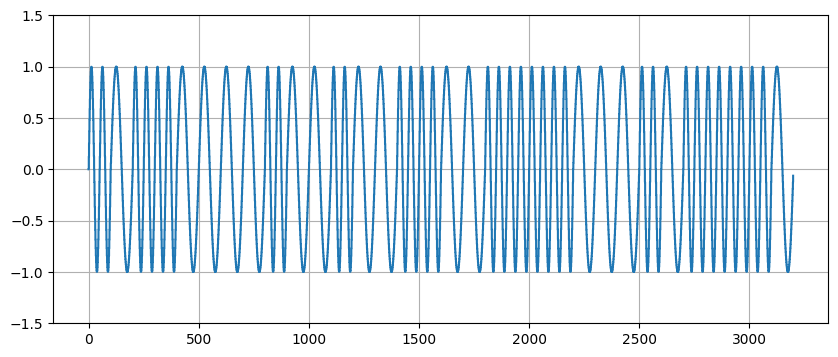

In [9]:
A = 1
f1 = 1
f2 = 2

fsk = transmissor.FSK(A, f1, f2, nrz_mod)

print(f"'{message_mod}' in NRZ - FSK: {nrz_mod}")

t = np.arange(len(fsk))

# Plot the binary wave
plt.figure(figsize=(10, 4))
plt.step(t, fsk, where='post')
plt.ylim([-1.5, 1.5])
plt.grid(True)
plt.show()


### 8qam

```py
class Mod_8qam:
    def __init__(self):
        self.taxa_modulacao = 8
        self.taxa_transmissao = 24

    def modulacao_8qam(self, bits):
        while len(bits) % 3 != 0:
            bits = np.append(bits, 0)

        bits_simbolos = [tuple(bits[i:i + 3]) for i in range(0, len(bits), 3)]

        # Constelacao para o 8QAM
        mapa = {
            (0, 0, 0): complex(-1, -1),
            (0, 0, 1): complex(-1, 1),
            (0, 1, 0): complex(1, -1),
            (0, 1, 1): complex(1, 1),
            (1, 0, 0): complex(-1, -3),
            (1, 0, 1): complex(-1, 3),
            (1, 1, 0): complex(1, -3),
            (1, 1, 1): complex(1, 3)
        }

        simbolos_modulados = [mapa[bits] for bits in bits_simbolos]

        return simbolos_modulados

    def banda_base_8qam(self, simbolos_modulados):
        duracao_simbolo = 1 / self.taxa_modulacao

        num_simbolos = len(simbolos_modulados)
        tempo_simbolo = np.linspace(0, duracao_simbolo, 100)

        tempo_total = np.linspace(
            0, duracao_simbolo * num_simbolos, num_simbolos * 100)
        forma_onda = np.zeros(len(tempo_total), dtype=complex)

        for i, simbolo in enumerate(simbolos_modulados):
            forma_onda[i * 100: (i + 1) * 100] = simbolo * np.exp(1j *
                                                                  2 * np.pi * self.taxa_modulacao * tempo_simbolo)

        num_bauds = len(simbolos_modulados)
        baud_duracao = 1 / self.taxa_transmissao
        tempo_total = np.linspace(0, baud_duracao * num_bauds, num_bauds * 100)

        return num_bauds, tempo_total, forma_onda

    def run(self, bits):
        simbolos_modulados = self.modulacao_8qam(bits)
        num_bauds, tempo, sinal_banda_base = self.banda_base_8qam(
            simbolos_modulados)

        return num_bauds, tempo, sinal_banda_base



O 8QAM, como diz o nome é a modulação de amplitude em quadratura em 8 pontos diferentes, tendo a diferença em amplitude e fase. Assim os cada digito de bit é modulado de acordo com o seu mapa de constelação de números complexos. Por exemplo, (000) -> -1-j. Para a plotagem do gráfico é necessário passar os pontos da constelação pela banda base.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


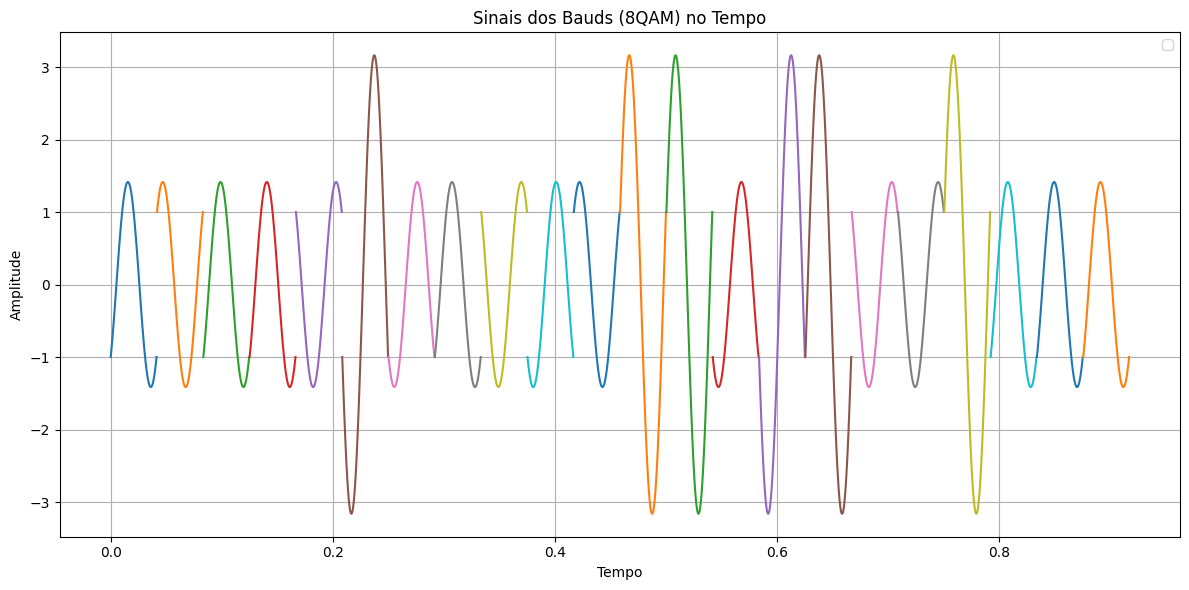

In [10]:
bauds, tempo, sinal_banda_base = transmissor.modulacao_8qam([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0])

plt.figure(figsize=(12, 6))

for i in range(bauds):
    plt.plot(tempo[i * 100: (i + 1) * 100],
             np.real(sinal_banda_base[i * 100: (i + 1) * 100])
            )

plt.title('Sinais dos Bauds (8QAM) no Tempo')
plt.xlabel('Tempo')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Note que cada cor diferente representa um Baude diferente.


# Enlace

## Métodos de Enquadramento de dados

### Contagem de Caracteres

Para fazer o enquadramento por meio da contagem de caracteres, o método divide a lista de bits em bytes (grupos de 8 bits) e os armazena em `bytes_list`. Em seguida, entra em um loop que continua até que `bytes_list` esteja vazio. Dentro do loop, a função calcula o tamanho do quadro como o mínimo entre o número de bytes restantes e o tamanho máximo do quadro menos um (para considerar o byte do cabeçalho). 

Em seguida, cria um quadro que consiste em um cabeçalho (que é o tamanho do quadro em formato binário de 8 bits) e os bytes que cabem no quadro. Este quadro é então adicionado à `frames_matrix`.

Finalmente, a função remove os bytes que foram adicionados ao quadro de `bytes_list` e repete o processo até que todos os bytes tenham sido enquadrados.

A função retorna a `frames_matrix`, que é uma lista de quadros, onde cada quadro é uma lista de strings de 8 bits.

Exemplo de funionamento:

In [11]:
transmissor = Transmissor("string_aleatoria")

bits_array = [0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0]
max_frame_size = 2

frames_matrix = transmissor.character_count_framing(bits_array, max_frame_size)

print(frames_matrix)

[['00000010', '01011010'], ['00000010', '01011010'], ['00000010', '01011010']]


### Inserção de Bytes

Para fazer o enquadramento por meio da contagem de caracteres, o método divide a lista de bits em bytes (grupos de 8 bits) e os armazena em `bytes_list`.A função define um byte_flag `01111110`.

Em seguida, entra em um loop que continua até que bytes_list esteja vazio. Dentro do loop, a função calcula o tamanho do quadro como o mínimo entre o número de bytes restantes e o tamanho máximo do quadro menos dois (para acomodar as flags de início e fim).

Em seguida, cria um quadro que consiste em uma flag de início, os bytes que cabem no quadro, e uma flag de fim. Este quadro é então adicionado à `frames_matrix`.

Finalmente, a função remove os bytes que foram adicionados ao quadro de bytes_list e repete o processo até que todos os bytes tenham sido enquadrados.
A função retorna a `frames_matrix`, que é uma lista de quadros, onde cada quadro é uma lista de strings de 8 bits.

Exemplo de funcionamento:

In [12]:
transmissor_teste = Transmissor("string_aleatoria")

bits_array = [0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0]
max_frame_size = 3

frames_matrix = transmissor.bytes_insertion_framing(bits_array, max_frame_size)

print(frames_matrix)

[['01111110', '01011010', '01111110'], ['01111110', '01011010', '01111110'], ['01111110', '01011010', '01111110']]


### Inserção de Bits

Para fazer o enquadramento por meio da contagem de caracteres, o método define a flag `01111110`.

A função então entra em um loop que percorre a lista de bits em incrementos do tamanho máximo do quadro. Para cada iteração, ela pega um segmento da lista de bits de tamanho max_frame_size e o converte em uma string de bits.

Cada quadro é então criado adicionando a flag no início e no fim da string de bits. Este quadro é adicionado à lista `frames_list`.

A função retorna a `frames_list`, que é uma lista de quadros, onde cada quadro é uma string de bits.

Observação: Nesse caso, max_frame_size define a quantidade de bits de dados que estarão presentes em cada quadro.

Exemplo de funcionamento:

In [13]:
transmissor_teste = Transmissor("str_aleatoria")

bits_array = [0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0]
max_frame_size = 5

frames_list = transmissor.bits_insertion_framing(bits_array, max_frame_size)

print(frames_list)

['011111100101101111110', '011111100100101111110', '011111100110101111110', '011111100010101111110', '01111110101001111110']


#

## Códigos de Correção e Detecção de Erros

## Bit de Paridade

O método desenvolvido para realizar a adição do bit de paridade, conta o número de uns (bits ligados) na lista de bits e armazena esse número em `count_ones`. 

Em seguida, define o bit de paridade, se o número de uns for ímpar, o bit de paridade é definido como 1. 

Finalmente, a função retorna a lista de bits com o bit de paridade adicionado no final.

Exemplo de funcionamento:

In [14]:
transmissor = Transmissor("str_aleatoria")

bits_array = [0, 1, 0, 1, 1, 0, 0]

bits_with_parity = transmissor.add_even_parity_bit(bits_array)

print(bits_with_parity)

[0, 1, 0, 1, 1, 0, 0, 1]


## CRC 32

O método desenvolvido para realizar a adição dos bits dos 32 bits do CRC 32, primeiro verifica se a lista de bits tem menos de 64 bits (tamanho constante escolhido para evitar problemas ao efetuar a divisão de polinômios). Se a lista tiver menos que 64 bits, ela preenche a lista com uma sequência de 0's e 1's ao final da string até que ela tenha 64 bits.

Em seguida, a função converte a lista de bits em uma string de bits e adiciona 32 zeros ao final para realização das operações de xor que estão envolvidas na operação de divisão de polinômios.

A função então entra em um loop que percorre cada bit na string de bits. Para cada bit, ela realiza uma operação XOR entre a string de bits e o polinômio CRC32 se o primeiro bit da string de bits for 1. Caso contrário (0), ela simplesmente remove o primeiro bit da string de bits.

Finalmente, a função retorna a string de bits original concatenada com a string de bits resultante da operação de cálculo dos 32 bits redundantes obtidos através da divisão dos polinômios, bem como o número de bits que foram inseridos para preencher a lista de bits original até 64 bits (Padding bits). É importante ressaltar, que para evitar o problema de grandes sequências de zeros, foi utilizada a função interna ao método `gen_0_1_sequence`, que gera uma sequência de uns e zeros, de forma consecutiva, começando sempre por 0.

Exemplo de funcionamento:

In [15]:
transmissor = Transmissor("str_aleatoria")

bits_array = [0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0]

bits_with_crc, inserted_bits_len = transmissor.crc32(bits_array)

print(f"Bits em forma de tring: {''.join(map(str, bits_with_crc))}", "\n")
print(f"Bits em forma de lista: {bits_with_crc}", "\n")
print(f"Quantidade de bits inseridos: {inserted_bits_len}")



Bits em forma de tring: 010110100101101001011010010101010101010101010101010101010101010111001000010100111100100000000010 

Bits em forma de lista: ['0', '1', '0', '1', '1', '0', '1', '0', '0', '1', '0', '1', '1', '0', '1', '0', '0', '1', '0', '1', '1', '0', '1', '0', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '1', '1', '0', '0', '1', '0', '0', '0', '0', '1', '0', '1', '0', '0', '1', '1', '1', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0'] 

Quantidade de bits inseridos: 40


# Código de Hamming

O método desenvolvio para gerar o código de hamming é dividido da seguinte maneira:

`find_len_redundant_bits(len_bits)`: Esta função interna calcula o número de bits de paridade necessários para um array de bits de um determinado tamanho. Ela faz isso procurando o menor número i tal que 2**i seja maior ou igual ao tamanho do array de bits mais i mais 1.

`insert_zeros_parity_position(bit_array)`: Esta função interna insere zeros nas posições dos bits de paridade no array de bits. As posições dos bits de paridade são potências de 2 (1, 2, 4, 8, etc.).

`calculate_parity_bit(bit_array, position)`: Esta função interna calcula o valor do bit de paridade para uma determinada posição. Ela faz isso coletando todos os bits que estão em posições que são múltiplos da posição do bit de paridade, e então fazendo um XOR de todos esses bits.

`insert_parity_bits(bit_array)`: Esta função interna insere os bits de paridade calculados nas posições corretas no array de bits.

A função `apply_hamming_code` então retorna o array de bits com os bits de paridade inseridos. Esses bits de paridade permitem que o receptor detecte e corrija erros que possam ter ocorrido durante a transmissão dos bits.

Exemplo de funcionamento:

In [16]:
transmissor = Transmissor("str_aleatoria")
bit_array = [1, 0, 1, 1, 0, 1, 0, 1]
encoded_bit_array = transmissor.apply_hamming_code(bit_array)
print(encoded_bit_array)

[0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1]


## Ajuste de Quadros

Essa é uma parte crucial do código para conseguir adaptar os quadros, visto que com os bits para detecção ou correção de erros inseridos, é necessário adaptar os quadros para que, no caso da contagem de caracteres e inserção de bytes, a quantidade total de bits úteis seja divisível por 8 bits, para poder dividir o trem de bits em bytes. 

Para isso, foi necessário definir as novas condições de cada metódo de enquadramento para cada um dos 3 métodos de correção/detecção de erros:

`adjust_frames_even_parity`: Este método adiciona um bit de paridade par a cada quadro. O bit de paridade é calculado de tal forma que o número total de bits 1 no quadro (incluindo o bit de paridade) seja sempre par. Além disso, se o tamanho do quadro não for um múltiplo de 8, nos casos de enqudramento por contagem de caracteres ou por inserção de bytes, bits de preenchimento (padding) são adicionados para torná-lo um múltiplo de 8.

`adjust_frames_crc`: Este método adiciona um código CRC a cada quadro e sempre passa um segundo header para todos os métodos de enqudramento, quantos bits de padding foram utilizados para completar a array de bits de dados para que ela seja completada até 64 bits, este valor já é calculado e retornado diretamente no método `crc32`. 

`adjust_frames_hamming`: Este método aplica o código de Hamming a cada quadro. Também adiciona bits adicionais quando necessáio para fazer o enquadramento por contagem de caracteres ou por inserção de bytes.

